########################################################
# EXPERIMENT CODE
########################################################

"""
Collects metadata about a user session for logging or reproducibility purposes.
This includes system details, user information, and optional project metadata.
It supports:
- Automatic population via environment variables.
- Interactive prompting if fields are missing (when `prompt_fields=True`).
- Fixed overrides for role and project ID if provided.
Useful in collaborative research, ML experiment tracking, or Jupyter environments.
"""

In [1]:
import os
import getpass
import platform
import sys
import uuid
from datetime import datetime

def prompt_if_none(env_key, prompt_text, default_value="unknown"):
    val = os.getenv(env_key)
    if not val:
        try:
            val = input(f"{prompt_text} (default: {default_value}): ").strip() or default_value
        except Exception:
            val = default_value
    return val

def collect_session_metadata(
    prompt_fields=True,
    fixed_role=None,
    fixed_project_id=None
):
    session_id = str(uuid.uuid4())
    
    session_metadata = {
        "session_id": session_id,
        "username": os.getenv("JUPYTERHUB_USER", getpass.getuser()),
        "timestamp_utc": datetime.utcnow().isoformat(),
        "hostname": platform.node(),
        "platform": platform.system(),
        "os_version": platform.version(),
        "python_version": sys.version.split()[0],
    }

    # Prompt or use defaults
    session_metadata["role"] = fixed_role or (
        prompt_if_none("RESEARCHER_ROLE", "Enter your role", "collaborator") if prompt_fields 
        else os.getenv("RESEARCHER_ROLE", "researcher")
    )
    session_metadata["project_id"] = fixed_project_id or (
        prompt_if_none("PROJECT_ID", "Enter project ID", "default_project") if prompt_fields 
        else os.getenv("PROJECT_ID", "default_project")
    )

    print("\n📌 Session Metadata:")
    for k, v in session_metadata.items():
        print(f"  {k}: {v}")

    return session_metadata


LIBRARY IMPORTS:

In [2]:
# ============================
# 📦 Standard Library Imports
# ============================
import os
import glob
import io
import json
import time
import ast
import pickle
import platform
import subprocess
from datetime import datetime, timezone
from pprint import pprint
from typing import List, Dict, Any
import xml.etree.ElementTree as ET
import urllib.parse
import yaml
from pathlib import Path



# ============================
# 📊 Data and Visualization
# ============================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# ============================
# 🤖 Machine Learning
# ============================
import sklearn
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
# ============================
# 🔬 Experiment Tracking
# ============================
import mlflow
import mlflow.sklearn
from mlflow import MlflowClient

# ============================
# 🌐 Web / API / Networking
# ============================
import requests
from dotenv import load_dotenv

# ============================
# 🧪 Git & Version Control
# ============================
import git
from git import Repo, GitCommandError
import hashlib


# ============================
# 🧠 SHAP for Explainability
# ============================
import shap

# ============================
# 🧬 RDF & Provenance (rdflib)
# ============================
from rdflib import Graph, URIRef, Literal
from rdflib.namespace import PROV, XSD

# ============================
# ⚙️ System Monitoring
# ============================
import psutil


#Dataset metadata!!!

#Metadata from ZONEDO

"""
Fetches and structures dataset metadata from a given DOI using the DataCite API.

This function:
- Sends a GET request to the DataCite API to retrieve metadata about a dataset.
- Extracts important fields (e.g., title, creator, publisher, version, license).
- Fills in placeholders like "info not available" when data is missing.
- Adds additional fields based on the PROV-O provenance model for traceability.

Returns a dictionary that can be used for logging, tracking, or enriching metadata
in data catalogs, ML pipelines, or reproducibility systems.
"""

In [3]:
import requests
from datetime import datetime
import pprint

def extract_dataset_metadata_from_doi(doi: str) -> dict:
    base_url = f"https://api.datacite.org/dois/{doi.lower()}"
    r = requests.get(base_url)
    r.raise_for_status()
    meta = r.json().get("data", {}).get("attributes", {})

    # Print all available raw metadata (for debugging/exploration)
    pprint.pprint(meta)

    # --- Standard metadata fields ---
    title = meta.get("titles", [{}])[0].get("title", "info not available")
    creators = [c.get("name", "") for c in meta.get("creators", [])]
    publisher = meta.get("publisher", "info not available")
    pub_year = meta.get("publicationYear", "info not available")
    url = meta.get("url", f"https://doi.org/{doi}")
    created = meta.get("created")
    updated = meta.get("updated")
    description = meta.get("descriptions", [])
    license_info = meta.get("rightsList", [])
    language = meta.get("language", "info not available")
    subjects = meta.get("subjects", [])
    related_ids = meta.get("relatedIdentifiers", [])
    citation_count = meta.get("citationCount", 0)
    registered = meta.get("registered", "")
    schema_version = meta.get("schemaVersion", "")
    citation_trend = meta.get("citationsOverTime", [])

    # --- Convert useful extras into strings ---
    dataset_description = description[0]["description"] if description else "info not available"
    dataset_license = license_info[0]["rights"] if license_info else "info not available"
    dataset_subjects = ", ".join(s.get("subject", "") for s in subjects) if subjects else "info not available"
    related_resources = [r.get("relatedIdentifier", "") for r in related_ids]

    # --- Structured output ---
    dataset_metadata = {
        "dataset_id": doi,
        "dataset_title": title,
        "dataset_creator": ", ".join(creators) if creators else "info not available",
        "dataset_publisher": publisher,
        "dataset_publication_date": pub_year,
        "dataset_description": dataset_description,
        "dataset_version": meta.get("version", "info not available"),
        "dataset_license": dataset_license,
        "dataset_subjects": dataset_subjects,
        "dataset_language": language,
        "dataset_access_url": url,
        "dataset_documentation": url,
        "metadata_standard": meta.get("types", {}).get("resourceTypeGeneral", "info not available"),
        "related_resources": related_resources,
        "citation_count": citation_count,
        "citations_over_time": citation_trend,
        "schema_version": schema_version,
        "registered_date": registered,
        "created": created,
        "updated": updated,

        # PROV-O traceability fields
        "prov_entity": title,
        "prov_activity": "Ingestion and Publication",
        "prov_agent_dataset_creator": ", ".join(creators) if creators else "info not available",
        "prov_used": url,
        "prov_wasDerivedFrom": doi,
        "prov_wasAttributedTo": ", ".join(creators) if creators else "info not available",
        "prov_startedAtTime": pub_year,
        "prov_role_dataset_creator": "Original Data Author",
        "prov_role_database_creator": "Database Ingestor and Maintainer"
    }

    return dataset_metadata


In [4]:
 # doi_metadata = extract_dataset_metadata_from_doi("10.24432/C56C76")

"""
Fetches and compiles structured metadata about a database table from a local API.

This function:
- Retrieves database-level metadata (e.g., name, owner, description).
- Retrieves versioned history for the specific table.
- Constructs a flat metadata dictionary with standardized and FAIR4ML/PROV-O–style fields.
- Can be used in ML pipelines, reproducibility tracking, or data cataloging systems.

Arguments:
- db_id (str): The database identifier.
- table_id (str): The table identifier within the database.
- selected_version (str): Version string for the dataset.
- target_variable (str): Name of the ML target column.
- num_samples (int): Number of data samples.

Returns:
- dict: A metadata dictionary or an empty dict if request fails.
"""

In [5]:
import requests

DB_API = "http://localhost/api/database/{db_id}"
HISTORY_API = "http://localhost/api/database/{db_id}/table/{table_id}/history"

def fetch_db_dataset_metadata(
    db_id: str,
    table_id: str,
    selected_version: str,
    target_variable: str,
    num_samples: int
) -> dict:
    try:
        # Fetch main DB metadata
        db_url = DB_API.format(db_id=db_id)
        db_response = requests.get(db_url)
        db_response.raise_for_status()
        db_data = db_response.json()
        print(db_data)

        # Fetch table history metadata
        history_url = HISTORY_API.format(db_id=db_id, table_id=table_id)
        history_response = requests.get(history_url)
        timestamp = "info not available"
        if history_response.status_code == 200:
            history_data = history_response.json()
            print(history_data)
            if isinstance(history_data, list) and len(history_data) > 0:
                timestamp = history_data[0].get("timestamp", timestamp)

        # Build flat metadata structure for DB storage
        dataset_metadata = {
            # Basic identity
            "dataset_id": table_id,
            "dataset_name": next(
                (t.get("name") for t in db_data.get("tables", []) if t.get("id") == table_id),
                "table name not available"
            ),
            "dataset_version": selected_version,
            "dataset_title": db_data.get("name", "info not available"),
            "dataset_description": db_data.get("description", "info not available"),

            # Ownership and access
            "dataset_creator": "info not available",
            "dataset_publisher": db_data.get("owner", {}).get("name", "info not available"),
            "dataset_access_url": db_url,
            "dataset_publication_date": timestamp,
            "dataset_license": "info not available",

            # Structure
            "columns": db_data.get("columns", "info not available"),
            "dataset_dataset_type": "tabular",
            "target_variable": target_variable,
            "ml_task": "classification",
            "num_samples": num_samples,

            # FAIR4ML placeholders
            "data_distribution": "info not available",
            "known_issues": "info not available",
            "trainedOn": "info not available",
            "testedOn": "info not available",
            "validatedOn": "info not available",
            "modelRisks": "info not available",
            "usageInstructions": "info not available",
            "ethicalLegalSocial": "info not available",

            # PROV-style fields
            "prov_entity": db_data.get("name", "info not available"),
            "prov_activity": "Ingestion and Publication",
            "prov_agent_dataset_creator": "info not available",
            "prov_agent_database_creator": db_data.get('owner', {}).get('name', 'info not available'),
            "prov_wasGeneratedBy": db_data.get('owner', {}).get('name', 'info not available'),
            "prov_used": db_url,
            "prov_wasDerivedFrom": "info not available",
            "prov_wasAttributedTo": "info not available",
            "prov_wasAssociatedWith": db_data.get('owner', {}).get('name', 'info not available'),
            "prov_startedAtTime": "info not available",
            "prov_endedAtTime": timestamp,
            "prov_location": db_url,
            "prov_role_dataset_creator": "",
            "prov_role_database_creator": "Database Ingestor and Maintainer"
        }

        return dataset_metadata

    except requests.exceptions.RequestException as e:
        print(f"[⚠️ Error] Failed to fetch DB metadata for {db_id}: {e}")
        return {}


"""
Interactive version selector for datasets stored in a version-controlled database.

This script:
- Maintains a mapping between dataset version tags (e.g., "v0", "v1") and actual table UUIDs.
- Prompts the user to select a version from a list of labeled options.
- Validates the input and returns the selected version along with the corresponding table UUID.
- Useful for ML or data analysis workflows where multiple versions of the same dataset exist.

Returns:
- selected_version (str): Version tag (e.g., "v2")
- selected_table_id (str): UUID of the selected table version
"""

In [7]:
# Mapping of version tags to table UUIDs
version_to_table_id = {
    "v0": "e9914484-a8b1-4bbc-b053-5f0ecba5a78b",  # Original
    "v1": "76b3d980-e160-4150-9195-a61b2157352f",  # Duplicated
    "v2": "240e4c71-b688-4644-8969-526d6cc5ef09",  # First 100
    "v3": "ab667e6c-12a6-4052-9448-6f2093de0655",  # Shuffled
    "v4": "95cf2caf-3f29-44bb-901d-cb2c1ea4bbe6" ,  # Normalized
    "v5": "18b87733-a87f-4059-930b-6854fdba81b0",   # Random
    "v6": "d5981cc3-7518-4f38-9144-003fcdb28ec7"  #possible replace for v2 dint work

}

db_id = "e95258f1-22c5-413f-9bf7-b0f2f6e947e8"  # Static DB ID

def select_dataset_version():
    print("Select dataset version:")
    print("  v0 - Original")
    print("  v1 - Duplicated")
    print("  v2 - First 100")
    print("  v3 - Shuffled")
    print("  v4 - Normalized")
    print("  v5 - Random")
    print("  v6 - test")

    
    
    selected_version = input("Enter version (v0–v5): ").strip().lower()
    
    if selected_version not in version_to_table_id:
        raise ValueError(f"❌ Invalid version selected: {selected_version}")
    
    selected_table_id = version_to_table_id[selected_version]
    
    print(f"\n✅ You selected version '{selected_version}' → Table ID: {selected_table_id}\n")
    
    return selected_version, selected_table_id

# Usage: #TODO CALL
selected_version, selected_table_id = select_dataset_version()


Select dataset version:
  v0 - Original
  v1 - Duplicated
  v2 - First 100
  v3 - Shuffled
  v4 - Normalized
  v5 - Random
  v6 - test


Enter version (v0–v5):  v6



✅ You selected version 'v6' → Table ID: d5981cc3-7518-4f38-9144-003fcdb28ec7



"""
Logs structured metadata to an active MLflow run.

This utility function:
- Logs each key-value pair in a flat metadata dictionary as MLflow tags.
- Optionally prefixes each key (e.g., "session_", "prov_").
- Skips empty or None values.
- Truncates long values and handles dicts/lists by serializing to JSON.
- Also saves the entire metadata dictionary as a JSON file and logs it as an MLflow artifact.

This function is useful for reproducibility, audit trails, experiment documentation, 
and standard-compliant ML metadata logging.

Args:
    metadata (dict): Flat dictionary of metadata fields.
    prefix (str): Optional prefix to prepend to each tag key.
    snapshot_name (str): Filename for saved full JSON snapshot artifact.

Raises:
    RuntimeError: If no MLflow run is active.
"""

In [8]:
import os
import json
import mlflow
# 
def log_metadata_dict_to_mlflow(metadata: dict, prefix: str = "", snapshot_name: str = "metadata_snapshot.json"):
    """
    Logs a flat metadata dictionary to MLflow:
    - Adds prefix to each key if provided (e.g., "session_")
    - Skips empty values
    - Logs a full JSON artifact for traceability
    """
    
    def safe_tag(key, value):
        if not mlflow.active_run():
            raise RuntimeError("❌ No active MLflow run.")
        
        key_clean = key.replace(":", "_").replace("/", "_").replace(" ", "_")
        try:
            val_str = json.dumps(value) if isinstance(value, (dict, list)) else str(value)
            if len(val_str) > 5000:
                val_str = val_str[:5000] + "...[TRUNCATED]"
            if len(key_clean) > 255:
                print(f"⚠️ Skipped tag (key too long): {key_clean}")
                return
            mlflow.set_tag(key_clean, val_str)
            print(f"✅ Logged tag: {key_clean}")
        except Exception as e:
            print(f"[⚠️ Error logging tag] {key_clean}: {e}")

    for key, value in metadata.items():
        if value not in [None, ""]:
            full_key = f"{prefix}{key}" if prefix else key
            safe_tag(full_key, value)

    # Save full metadata snapshot as JSON artifact
    os.makedirs("metadata", exist_ok=True)
    full_path = os.path.join("metadata", snapshot_name)
    with open(full_path, "w", encoding="utf-8") as f:
        json.dump(metadata, f, indent=2)
    
    mlflow.log_artifact(full_path, artifact_path="metadata")
    print(f"📁 Full metadata snapshot logged as: {snapshot_name}")


"""
Fetches dataset content from a specific versioned table using the local API.

This script:
- Constructs a GET request to retrieve data from a specified database table.
- Sends the request with appropriate headers.
- Parses and prints the response JSON if successful.
- Handles and reports errors gracefully.

Useful for loading versioned datasets (e.g., for analysis or ML training)
from a metadata-aware data management backend.

Assumes:
- `db_id` and `selected_table_id` are already defined.
"""

In [9]:
# API endpoint URL
API_URL = f"http://localhost/api/database/{db_id}/table/{selected_table_id}/data?size=100000&page=0"

# Define the headers
headers = {
    "Accept": "application/json"  # Specify the expected response format
}

try:
    # Send a GET request to the API with the Accept header
    response = requests.get(API_URL, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        dataset = response.json()
        
        
        print( dataset)
    else:
        print(f"Error: Received status code {response.status_code}")
        print("Response content:", response.text)
       

except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")


[{'id': '1', 'random_feature_1': '0.374540118847362500', 'random_feature_2': '0.908265885966653600', 'species': 'setosa'}, {'id': '2', 'random_feature_1': '0.950714306409916200', 'random_feature_2': '0.239561890666972400', 'species': 'setosa'}, {'id': '3', 'random_feature_1': '0.731993941811405100', 'random_feature_2': '0.144894872091223100', 'species': 'setosa'}, {'id': '4', 'random_feature_1': '0.598658484197036600', 'random_feature_2': '0.489452760277563000', 'species': 'setosa'}, {'id': '5', 'random_feature_1': '0.156018640442436500', 'random_feature_2': '0.985650454110600800', 'species': 'setosa'}, {'id': '6', 'random_feature_1': '0.155994520336202600', 'random_feature_2': '0.242055271511500400', 'species': 'setosa'}, {'id': '7', 'random_feature_1': '0.058083612168199400', 'random_feature_2': '0.672135547405878600', 'species': 'setosa'}, {'id': '8', 'random_feature_1': '0.866176145774935200', 'random_feature_2': '0.761619615328717600', 'species': 'setosa'}, {'id': '9', 'random_fea

replacing dynamic fetching of data When and if DBREPO isnt running (BACKUP)

In [10]:
# # 1. Read the JSON file id the API isnt available this data is saved locally but the data is from the API endpoint
# with open("iris_data.json", "r") as f:
#     dataset = json.load(f)


# ============================
# 📂 Setup MLflow
# ============================

"""
Initializes MLflow tracking with a local SQLite backend.

This script:
- Ensures a local directory (`mlrunlogs/`) exists for MLflow logs and database.
- Sets MLflow's tracking URI to a local SQLite database (`mlflow.db`).
- Prompts the user to enter an experiment name; falls back to 'default_experiment' if none is given.
- Registers or activates the specified experiment.

Useful for local ML experimentation, reproducibility, and metadata tracking
without needing a remote MLflow server.
"""

In [11]:
import os
import mlflow

# Ensure tracking directory exists
project_dir = os.getcwd()
mlrunlogs_dir = os.path.join(project_dir, "mlrunlogs")
os.makedirs(mlrunlogs_dir, exist_ok=True)

# Set MLflow tracking URI (local SQLite backend)
mlflow_tracking_path = os.path.join(mlrunlogs_dir, "mlflow.db")
mlflow.set_tracking_uri("mlrunlogs/mlflow.db")

# Prompt for experiment name
experiment_name = input("Enter experiment name for MLflow: ").strip()
if not experiment_name:
    experiment_name = "default_experiment"
    print("⚠️ No name entered. Using fallback:", experiment_name)

mlflow.set_experiment(experiment_name)


Enter experiment name for MLflow:  defghjk


2025/06/16 21:09:06 INFO mlflow.tracking.fluent: Experiment with name 'defghjk' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/reema/REPO/notebooks/RQ_notebooks/mlrunlogs/mlflow.db/311535253688028355', creation_time=1750100946104, experiment_id='311535253688028355', last_update_time=1750100946104, lifecycle_stage='active', name='defghjk', tags={}>

# ============================
# 🔄 Git Commit Hash for previous commit for metadata
# ============================

"""
Extracts metadata from the latest Git commit in a specified local repository.

This function:
- Connects to a Git repository at the provided path.
- Retrieves metadata from the latest commit, including commit hash, author, time, message, and branch.
- Handles detached HEAD states (e.g., in CI/CD or temp checkouts).
- Returns placeholder values if the repository is inaccessible or invalid.

Useful for:
- Logging code version info into ML experiment tracking (e.g., MLflow).
- Reproducibility audits.
- Attaching Git context to research or development metadata.

Returns:
    dict: Git metadata fields, or 'not available' if any error occurs.
"""


In [12]:
import git
import os

def get_latest_git_commit(repo_path: str = "C:/Users/reema/REPO") -> dict:
    """
    Returns the latest Git commit metadata from the given repo path.
    """
    try:
        repo = git.Repo(repo_path)
        commit = repo.head.commit
        commit_metadata = {
            "git_commit": commit.hexsha,
            "git_author": commit.author.name,
            "git_email": commit.author.email,
            "git_commit_time": str(commit.committed_datetime),
            "git_message": commit.message.strip(),
            "git_branch": repo.active_branch.name if not repo.head.is_detached else "detached"
        }
        return commit_metadata

    except Exception as e:
        print(f"[⚠️ Git Error] Could not read Git repo at {repo_path}: {e}")
        return {
            "git_commit": "not available",
            "git_author": "not available",
            "git_email": "not available",
            "git_commit_time": "not available",
            "git_message": "not available",
            "git_branch": "not available"
        }

# Usage
repo_dir = "C:/Users/reema/REPO"
git_metadata = get_latest_git_commit(repo_dir)


# ============================
# Make threadpoolctl safe so MLflow’s autologger won’t crash ───
# ============================

"""
Patches `threadpoolctl` to avoid crashes with MLflow autologging,
then enables MLflow's automatic logging for supported ML libraries 
(e.g., scikit-learn, XGBoost, LightGBM, TensorFlow, etc.).

This is particularly useful in environments where `threadpoolctl.threadpool_info()` 
may raise runtime errors (e.g., inside Docker or limited-thread environments).
"""

In [13]:
# ─── Patch threadpoolctl if needed to avoid autolog crashes ───
try:
    import threadpoolctl
    _original_threadpool_info = threadpoolctl.threadpool_info

    def _safe_threadpool_info(*args, **kwargs):
        try:
            return _original_threadpool_info(*args, **kwargs)
        except Exception:
            return []

    threadpoolctl.threadpool_info = _safe_threadpool_info
except ImportError:
    pass  # If threadpoolctl isn't installed, we just skip this patch

# ─── Enable MLflow autologging (generic, works with sklearn and more) ───
import mlflow

mlflow.autolog(
    log_input_examples=True,
    log_model_signatures=True
)


2025/06/16 21:09:13 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/06/16 21:09:14 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


"""
Logs a comprehensive set of metadata to MLflow for an ML experiment run.

This function:
- Captures model metadata, evaluation metrics, hyperparameters, label encodings.
- Logs preprocessing configuration and creates a unique hash for reproducibility.
- Tracks the compute environment and Git commit for traceability.
- Includes support for FAIR and MLSEA-aligned metadata standards.
- Optionally adds previously logged justification tags (e.g., from interactive inputs).

Useful for:
- ML provenance tracking
- Reproducibility and auditability of experiments
- Visualizing metadata-rich runs in MLflow dashboards
"""

In [14]:
import hashlib
import json
import platform
import psutil
import numpy as np
import pandas as pd
from datetime import datetime
from subprocess import check_output, CalledProcessError

def log_standard_metadata(
    model_name: str,
    model,
    hyperparams: dict,
    acc: float,
    prec: float,
    rec: float,
    f1: float,
    auc: float,
    label_map: dict,
    run_id: str,
    test_size: float,
    random_state: int,
    id_cols: list,
    target_col: str,
    X,
    y,
    run_data=None
):
    # === Experiment Metadata ===
    mlflow.set_tag("run_id", run_id)  # [MLflow / DB anchor]
    mlflow.set_tag("model_name", model_name)  # [ML Metadata, FAIR]
    mlflow.set_tag("model_architecture", model.__class__.__name__)  # [MLSEA]
    mlflow.set_tag("test_size", test_size)  # [MLSEA, Reproducibility]
    mlflow.set_tag("random_state", random_state)  # [MLSEA, Reproducibility]

    # === Evaluation Metrics ===
    mlflow.set_tag("accuracy", acc)
    mlflow.set_tag("precision_macro", prec)
    mlflow.set_tag("recall_macro", rec)
    mlflow.set_tag("f1_macro", f1)
    mlflow.set_tag("roc_auc", auc)

    # === Hyperparameters and Label Encoding ===
    mlflow.set_tag("hyperparameters", json.dumps(hyperparams))  # [FAIR, MLSEA]
    mlflow.set_tag("label_map", json.dumps(label_map))  # [ML Preprocessing]

    # === Preprocessing Snapshot ===
    preprocessing_info = {
        "dropped_columns": id_cols,
        "numeric_columns": list(X.columns),
        "target_column": target_col,
        "stratified": False,
        "coercion_strategy": "Numeric cast (auto)",
        "feature_engineering": "None",
        "missing_value_strategy": "None",
        "outlier_detection": "None",
        "encoding_strategy": "LabelEncoder (target only)",
        "scaling": "None",
        "sampling": "None",
        "feature_selection": "None",
        "train_test_split": {"test_size": test_size, "random_state": random_state},
        "imbalance_ratio": str(dict(zip(*np.unique(y, return_counts=True)))),
        "preprocessing_timestamp": datetime.now().isoformat()
    }
    preprocessing_hash = hashlib.sha256(json.dumps(preprocessing_info).encode()).hexdigest()
    mlflow.set_tag("preprocessing_info", json.dumps(preprocessing_info))  # [MLSEA]
    mlflow.set_tag("preprocessing_hash", preprocessing_hash)

    # === Reproducibility ===
    mlflow.set_tag("model_serialization", "pickle")  # [FAIR, MLSEA]
    mlflow.set_tag("model_path", f"{model_name}.pkl")

    try:
        sha = check_output(["git", "rev-parse", "HEAD"], text=True).strip()
    except CalledProcessError:
        sha = "unknown"
    mlflow.set_tag("git_commit", sha)

    # === Compute Environment ===
    compute_env = {
        "os": f"{platform.system()} {platform.release()}",
        "cpu": platform.processor(),
        "ram_gb": round(psutil.virtual_memory().total / (1024 ** 3), 2),
        "python_version": platform.python_version(),
        "sklearn_version": sklearn.__version__,
        "pandas_version": pd.__version__,
        "numpy_version": np.__version__,
    }
    mlflow.set_tag("compute_environment", json.dumps(compute_env))  # [Reproducibility]

    # === Optional: Tag MLflow Justifications (previously logged manually) ===
    if run_data:
        for key, val in run_data.tags.items():
            if key.startswith("justification_"):
                mlflow.set_tag(key, val)


"""
Generates a comprehensive reproducibility text log for a machine learning model run.

This function:
- Compiles metadata including model/dataset identifiers, hyperparameters, evaluation metrics, 
  Git commit hash, and a structured reproduction guide.
- Optionally appends a system architecture description if the file is available.
- Saves the log in a YAML-formatted `.txt` file under the `MODEL_PROVENANCE/` directory,
  nested by model name.

Intended use:
- Auditable experiment tracking
- Research paper supplementary material
- Automated logging in ML pipelines
"""


In [15]:
import os
import yaml
import numpy as np
from datetime import datetime

def generate_reproducibility_txt_log(
    model_name: str,
    dataset_name: str,
    dataset_version: str,
    hyperparams: dict,
    metrics: dict,
    git_commit: str,
    run_id: str,
    architecture_file_path: str = "provenance_architecture_description.txt"
) -> str:
    """
    Generate a reproducibility log (YAML + architecture) and return the saved path.
    This log combines:
    - Model and dataset details
    - Hyperparameters and evaluation metrics
    - Git provenance info
    - Reproduction steps
    - Provenance architecture description
    """

    def clean_values(d):
        """Convert numpy floats to native floats."""
        return {k: float(v) if isinstance(v, (np.float32, np.float64)) else v for k, v in d.items()}

    timestamp = datetime.utcnow().strftime("%Y-%m-%d %H:%M UTC")

    repro_data = {
        "📌 Model Details": {
            "Model Name": model_name,
            "Dataset Name": dataset_name,
            "Dataset Version": dataset_version,
            "Run ID": run_id,
            "Timestamp": timestamp
        },
        "🛠️ Hyperparameters": clean_values(hyperparams),
        "📈 Metrics": clean_values(metrics),
        "🔗 Git Info": {
            "Commit Hash": git_commit,
            "Reproduce With": f"git checkout {git_commit}"
        },
        "🚀 Reproduction Guide": [
            "1. Clone the repo and checkout the commit:",
            f"   git checkout {git_commit}",
            "2. Load and preprocess the dataset exactly as during training.",
            "3. Load the model using MLflow:",
            f"   mlflow.sklearn.load_model('runs:/{run_id}/model')",
            "4. Run inference or evaluation using the same pipeline/script."
        ]
    }

    # 🔐 Create and write to output file
    save_dir = os.path.join("MODEL_PROVENANCE", model_name)
    os.makedirs(save_dir, exist_ok=True)
    txt_path = os.path.join(save_dir, f"{model_name}_reproducibility.txt")

    with open(txt_path, "w", encoding="utf-8") as repro_file:
        yaml.dump(repro_data, repro_file, allow_unicode=True, sort_keys=False, width=100)
        repro_file.write("\n\n")

        if os.path.exists(architecture_file_path):
            with open(architecture_file_path, "r", encoding="utf-8") as arch_file:
                architecture_description = arch_file.read()
                repro_file.write(architecture_description)
        else:
            repro_file.write("[⚠️ Missing architecture description file]\n")

    return txt_path


"""
Utility functions for collecting human-in-the-loop justifications during ML experimentation.

These functions:
- Allow logging of parameter values or decisions via MLflow.
- Prompt the user to provide justifications for those values interactively.
- Store justifications as MLflow tags prefixed with `justification_`.

This supports transparency, documentation, and accountability in model development,
especially in research or regulated environments.
"""


In [16]:
def log_with_justification(log_func, key: str, value, context: str = ""):
    """
    Log a value using the specified MLflow log function (e.g., mlflow.log_param),
    then prompt the user for a justification and log it as a tag.
    """
    log_func(key, value)
    print(f"\n📝 Justification for `{key}` ({context})")
    user_reason = input("→ Why did you choose this value? ")
    mlflow.set_tag(f"justification_{key}", user_reason or "No justification provided")

def log_justification(key: str, question: str):
    """
    Prompt for a justification only (without logging a value), and log it as a tag.
    """
    print(f"\n📝 Justification for `{key}`")
    user_reason = input(f"→ {question} ")
    mlflow.set_tag(f"justification_{key}", user_reason or "No justification provided")


In [17]:
# mlflow.end_run()

# ============================
# 🚀 Start MLflow Run 
# ============================

Enter your role (default: collaborator):  
Enter project ID (default: default_project):  thesis



📌 Session Metadata:
  session_id: 523d98f9-c85b-4e54-a266-209b2becf31a
  username: reema
  timestamp_utc: 2025-06-16T19:09:19.795727
  hostname: Purplish
  platform: Windows
  os_version: 10.0.26100
  python_version: 3.11.5
  role: collaborator
  project_id: thesis
{'alternateIdentifiers': [],
 'citationCount': 23,
 'citationsOverTime': [{'total': 5, 'year': '2023'},
                       {'total': 11, 'year': '2024'},
                       {'total': 7, 'year': '2025'}],
 'container': {},
 'contentUrl': None,
 'contributors': [],
 'created': '2023-03-16T12:57:44.000Z',
 'creators': [{'affiliation': [],
               'name': 'R. A. Fisher',
               'nameIdentifiers': []}],
 'dates': [{'date': '1936', 'dateType': 'Issued'}],
 'descriptions': [],
 'doi': '10.24432/c56c76',
 'downloadCount': 0,
 'downloadsOverTime': [],
 'formats': [],
 'fundingReferences': [],
 'geoLocations': [],
 'identifiers': [],
 'isActive': True,
 'language': None,
 'metadataVersion': 1,
 'partCount': 0,


Enter test size (e.g., 0.2 for 20% test set):  0.5
Enter random seed (e.g., 42):  78


Choose a model to train:
1. random_forest
2. decision_tree
3. logistic_regression
4. knn
5. svm
6. gradient_boosting


Enter model number (default 1 for random_forest):  



📝 Justification for `n_estimators` (Hyperparameter configuration)


→ Why did you choose this value?  Test case values



📝 Justification for `criterion` (Hyperparameter configuration)


→ Why did you choose this value?  Test case values



📝 Justification for `max_depth` (Hyperparameter configuration)


→ Why did you choose this value?  Test case values



📝 Justification for `min_samples_split` (Hyperparameter configuration)


→ Why did you choose this value?  Test case values



📝 Justification for `min_samples_leaf` (Hyperparameter configuration)


→ Why did you choose this value?  Test case values



📝 Justification for `max_features` (Hyperparameter configuration)


→ Why did you choose this value?  Test case values



📝 Justification for `bootstrap` (Hyperparameter configuration)


→ Why did you choose this value?  Test case values



📝 Justification for `oob_score` (Hyperparameter configuration)


→ Why did you choose this value?  Test case values



📝 Justification for `class_weight` (Hyperparameter configuration)


→ Why did you choose this value?  Test case values



📝 Justification for `verbose` (Hyperparameter configuration)


→ Why did you choose this value?  Test case values



📝 Justification for `n_jobs` (Hyperparameter configuration)


→ Why did you choose this value?  Test case values


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished



📝 Justification for `model_choice`


→ Why did you choose this model (e.g., RandomForestClassifier) for this task?  Test case values



📝 Justification for `target_variable`


→ Why did you choose this column as the prediction target?  Test case values



📝 Justification for `test_split`


→ Why this train/test ratio (e.g., 80/20)?  Test case values



📝 Justification for `metric_choice`


→ Why did you use accuracy/f1/ROC-AUC as your evaluation metric?  Test case values



📝 Justification for `threshold_accuracy`


→ Was there a threshold for accuracy? Why?  Test case values



📝 Justification for `dataset_version`


→ Why did you use this specific dataset version?  Test case values



📝 Justification for `drop_column_X`


→ Why did you drop any specific columns from the dataset?  Test case values



📝 Justification for `experiment_name`


→ Any context behind this experiment name or setup?  Test case values



📝 Justification for `model_limitations`


→ Any known model limitations?  Test case values



📝 Justification for `ethical_considerations`


→ Any known model ethical considerations?  Test case values



📝 Justification for `intended_use`


→ Known model intended use?  Test case values



📝 Justification for `not_intended_for`


→ Model not_intended_for?  Test case values


IndexError: index 2 is out of bounds for axis 1 with size 2

<Figure size 640x480 with 0 Axes>

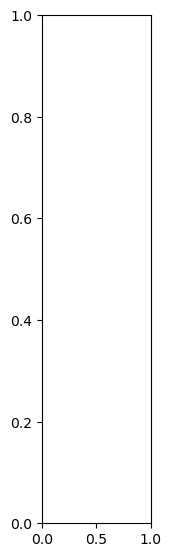

In [18]:
import hashlib
from datetime import datetime
import mlflow
import pandas as pd

with mlflow.start_run() as run:
    client = MlflowClient()
    run_data = client.get_run(run.info.run_id).data
    # ─────────────── Session Metadata ─────────────────────────────────────
    session_metadata = collect_session_metadata(prompt_fields=True)
    mlflow.log_params(session_metadata)  # [PROV, Internal] Session and environment context

    # ─────────────── Dataset Metadata ─────────────────────────────────────
    doi_metadata = extract_dataset_metadata_from_doi("10.24432/C56C76")  # [FAIR, PROV, FAIR4ML]

    # ─────────────── Experiment Start Time ────────────────────────────────
    start_time = datetime.now().isoformat()
    mlflow.set_tag("startedAtTime", start_time)  # [PROV] Activity start time

    #######################################################################
    ### Preprocessing #####################################################

    # ── Load into a DataFrame ────────────────────────────────────────────
    df = pd.DataFrame(dataset)
    original_row_count = df.shape[0]
    mlflow.log_param("input_row_count", original_row_count)  # [MLSEA] Input data size

    # Log column names before transformation
    mlflow.set_tag("raw_columns", ','.join(df.columns))  # [FAIR4ML, Internal]

    # ── Generate row hashes ───────────────────────────────────────────────
    before_hashes = set(df.astype(str).apply(lambda row: hash(tuple(row)), axis=1))
    mlflow.set_tag("row_hash_tracking", "enabled")  # [Internal] Used for provenance/repeatability

    # ── Extract target variable ───────────────────────────────────────────
    target_col = df.columns[-1]
    mlflow.set_tag("target_variable", target_col)  # [FAIR4ML, MLSEA]

    # ── Separate features and labels ──────────────────────────────────────
    y = df[target_col]
    X = df.drop(columns=[target_col])
    mlflow.set_tag("feature_columns", ','.join(X.columns))  # [FAIR4ML, MLSEA]

    # ── Drop ID columns (case-insensitive) ────────────────────────────────
    id_cols = [c for c in X.columns if c.lower() == "id"]
    if id_cols:
        X = X.drop(columns=id_cols)
        mlflow.set_tag("dropped_id_columns", ','.join(id_cols))  # [Internal]

    # ── Convert columns to numeric where possible ─────────────────────────
    numeric_conversion_count = 0
    for c in X.columns:
        try:
            X[c] = pd.to_numeric(X[c])
            numeric_conversion_count += 1
        except Exception:
            continue
    mlflow.log_param("numeric_columns_converted", numeric_conversion_count)  # [Internal, FAIR4ML]

    # ── Print diagnostic info ─────────────────────────────────────────────
    print("ML_EXP_Shapes:", X.shape, y.shape)
    mlflow.log_param("feature_matrix_shape", str(X.shape))  # [MLSEA]
    mlflow.log_param("label_vector_shape", str(y.shape))    # [MLSEA]
#######################################################################################################
### 8) Label Encoding and Metadata Logging ############################################################

# ── Encode class labels numerically ────────────────────────────────────────────────────────
    le = LabelEncoder()
    y = le.fit_transform(y)
    print("ML_EXP_Classes:", le.classes_)
    
    mlflow.set_tag("class_names", ','.join(le.classes_))  # [FAIR4ML, MLSEA]
    
    # ── Count rows and hash comparison before vs after preprocessing ────────────────────────────
    count_end = df.shape[0]
    after_hashes = set(df.astype(str).apply(lambda row: hash(tuple(row)), axis=1))
    
    n_insert = len(after_hashes - before_hashes)
    n_delete = len(before_hashes - after_hashes)
    
    #######################################################################################################
    ### Metadata Logging (Standardized Format) ############################################################
    
    # ── Extended DB Metadata ────────────────────────────────────────────────────────────────────
    db_meta = fetch_db_dataset_metadata(db_id, selected_table_id, selected_version, target_col, df.shape[0])  # [Internal]
    
    mlflow.set_tag("Internal_DBRepo_table_last_modified", db_meta.get("dataset_publication_date", "unknown"))
  # [PROV]
    
    # ── Row Count Metrics ────────────────────────────────────────────────────────────────────────
    mlflow.log_metric("row_count_start", original_row_count)              # [MLSEA, FAIR4ML]
    mlflow.log_metric("row_count_end", count_end)                  # [MLSEA, FAIR4ML]
    mlflow.log_metric("num_inserted_rows", n_insert)               # [PROV]
    mlflow.log_metric("num_deleted_rows", n_delete)                # [PROV]
    
    # ── Raw Data Source Metadata ─────────────────────────────────────────────────────────────────
    mlflow.set_tag("data_source", API_URL)                         # [FAIR]
    mlflow.log_param("retrieval_time_utc", datetime.utcnow().isoformat())  # [PROV]
    mlflow.log_param("raw_row_count", len(df))                     # [MLSEA]
    mlflow.log_param("raw_columns", df.columns.tolist())           # [FAIR4ML]
    mlflow.log_param("dropped_columns", id_cols)                   # [Internal]
    
    # ── Post-Processing Metadata ─────────────────────────────────────────────────────────────────
    mlflow.log_param("final_num_features", X.shape[1])             # [MLSEA]
    mlflow.log_param("final_feature_names", X.columns.tolist())    # [FAIR4ML]
    mlflow.set_tag("target_variable_encoded", target_col)          # [FAIR4ML]
    
    # ── Label Mapping as Artifact ───────────────────────────────────────────────────────────────
    label_map = {int(idx): cls for idx, cls in enumerate(le.classes_)}
    buffer = io.StringIO()
    json.dump(label_map, buffer, indent=2)
    buffer.seek(0)
    mlflow.log_text(buffer.getvalue(), artifact_file="label_mapping.json")  # [FAIR4ML]
    
    # ── Training Metadata ────────────────────────────────────────────────────────────────────────
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_name = f"RandomForest_Iris_v{ts}"
    mlflow.set_tag("model_name", model_name)                       # [MLSEA]
    
    train_start_ts = datetime.now().isoformat()
    mlflow.set_tag("training_start_time", train_start_ts)          # [PROV]
########################################################################################################
### Model Parameters & Split Metadata ##################################################################

# ── Prompt test size and seed ─────────────────────────────────────────────────────────────────────────
    try:
        test_size = float(input("Enter test size (e.g., 0.2 for 20% test set): "))
    except ValueError:
        print("Invalid input. Defaulting to 0.2")
        test_size = 0.2
    
    try:
        random_state = int(input("Enter random seed (e.g., 42): "))
    except ValueError:
        print("Invalid input. Defaulting to 42")
        random_state = 42
    
    # ── Train/test split ────────────────────────────────────────────────────────────────────────────────
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # ── Log split config ────────────────────────────────────────────────────────────────────────────────
    mlflow.log_param("test_size", test_size)                     # [MLSEA]
    mlflow.log_param("random_seed", random_state)               # [PROV]
    mlflow.log_param("n_train_samples", X_train.shape[0])       # [FAIR4ML]
    mlflow.log_param("n_test_samples",  X_test.shape[0])        # [FAIR4ML]
    mlflow.log_param("n_features",      X_train.shape[1])       # [MLSEA]
    
    ########################################################################################################
    ### Model Selection & Hyperparameters ##################################################################
    
    # ── Define hyperparameters ───────────────────────────────────────────────────────────────────────────
    ML_EXP_hyperparams = {
        "n_estimators":       100,
        "criterion":          "entropy",
        "max_depth":          10,
        "min_samples_split":  3,
        "min_samples_leaf":   1,
        "max_features":       "sqrt",
        "bootstrap":          True,
        "oob_score":          True,
        "class_weight":       None,
        "verbose":            1,
        "n_jobs":             -1
    }
    
    # ── Model selection ───────────────────────────────────────────────────────────────────────────────────
    available_models = {
        "random_forest": RandomForestClassifier,
        "decision_tree": DecisionTreeClassifier,
        "logistic_regression": LogisticRegression,
        "knn": KNeighborsClassifier,
        "svm": SVC,
        "gradient_boosting": GradientBoostingClassifier
    }
    
    # User prompt
    print("Choose a model to train:")
    for i, name in enumerate(available_models.keys()):
        print(f"{i + 1}. {name}")
    
    choice = input("Enter model number (default 1 for random_forest): ").strip()
    choice = int(choice) if choice else 1
    selected_key = list(available_models.keys())[choice - 1]
    selected_model_class = available_models[selected_key]
    mlflow.set_tag("selected_model", selected_key)  # [FAIR4ML, MLSEA]
    
    # ── Initialize model ────────────────────────────────────────────────────────────────────────────────
    model = selected_model_class(**ML_EXP_hyperparams)
    
    # ── Log hyperparameters with justification ───────────────────────────────────────────────────────────
    for key, val in ML_EXP_hyperparams.items():
        log_with_justification(mlflow.log_param, key, val, context="Hyperparameter configuration")  # [FAIR4ML, MLSEA]
    
    ########################################################################################################
    ### Model Training & Evaluation ########################################################################
    
    # ── Fit the model ────────────────────────────────────────────────────────────────────────────────────
    model.fit(X_train, y_train)
    train_end_ts = datetime.now().isoformat()
    mlflow.set_tag("training_end_time", train_end_ts)  # [PROV]
    
    # ── Predictions ──────────────────────────────────────────────────────────────────────────────────────
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    # ── Compute and log metrics ─────────────────────────────────────────────────────────────────────────
    acc  = accuracy_score(y_test, y_pred)
    auc  = roc_auc_score(y_test, y_proba, multi_class="ovr")
    prec = precision_score(y_test, y_pred, average="macro")
    rec  = recall_score(y_test,  y_pred, average="macro")
    f1   = f1_score(y_test,      y_pred, average="macro")
    
    mlflow.log_metric("accuracy", acc)              # [MLSEA]
    mlflow.log_metric("roc_auc", auc)               # [MLSEA]
    mlflow.log_metric("precision_macro", prec)      # [MLSEA]
    mlflow.log_metric("recall_macro", rec)          # [MLSEA]
    mlflow.log_metric("f1_macro", f1)               # [MLSEA]


########################################################################################################
### Final Logging: Justifications, Metrics, Environment, Dataset Metadata #############################

# ── Prompt for and log justifications ────────────────────────────────────────────────────────────────
    log_justification("model_choice", "Why did you choose this model (e.g., RandomForestClassifier) for this task?")
    log_justification("target_variable", "Why did you choose this column as the prediction target?")
    log_justification("test_split", "Why this train/test ratio (e.g., 80/20)?")
    log_justification("metric_choice", "Why did you use accuracy/f1/ROC-AUC as your evaluation metric?")
    log_justification("threshold_accuracy", "Was there a threshold for accuracy? Why?")
    log_justification("dataset_version", "Why did you use this specific dataset version?")
    log_justification("drop_column_X", "Why did you drop any specific columns from the dataset?")
    log_justification("experiment_name", "Any context behind this experiment name or setup?")
    log_justification("model_limitations", "Any known model limitations?")
    log_justification("ethical_considerations", "Any known model ethical considerations?")
    log_justification("intended_use", "Known model intended use?")
    log_justification("not_intended_for", "Model not_intended_for?")


    # ── Log model evaluation metrics ────────────────────────────────────────────────────────────────────
    mlflow.log_metric("precision_macro", prec)    # [MLSEA]
    mlflow.log_metric("recall_macro", rec)        # [MLSEA]
    mlflow.log_metric("f1_macro", f1)             # [MLSEA]
    mlflow.log_metric("accuracy", acc)            # [MLSEA]
    mlflow.log_metric("roc_auc", auc)             # [MLSEA]
    
    # ── Log environment info ─────────────────────────────────────────────────────────────────────────────
    mlflow.log_params({
        "python_version":       platform.python_version(),
        "os_platform":          f"{platform.system()} {platform.release()}",
        "sklearn_version":      sklearn.__version__,
        "pandas_version":       pd.__version__,
        "numpy_version":        np.__version__,
        "matplotlib_version":   matplotlib.__version__,
        "seaborn_version":      sns.__version__,
        "shap_version":         shap.__version__,
    })  # [PROV, Internal]
    
    # ── Tag notebook name ────────────────────────────────────────────────────────────────────────────────
    mlflow.set_tag("notebook_name", "RQ1_2.ipynb")  # [Internal]
    
    # ── Dataset metadata tags ────────────────────────────────────────────────────────────────────────────
    mlflow.set_tag("dataset_name",    db_meta.get("dataset_name", "unknown") )    # [FAIR4ML, PROV]
    mlflow.set_tag("dataset_version", selected_version)                                           # [FAIR4ML, Internal]
    mlflow.set_tag("dataset_id",      selected_table_id)  # [FAIR4ML, Internal]

########################################################################################################
### Plots: Feature Importance, ROC, PR, Confusion Matrix, SHAP #########################################

# ── Create plot output directory ─────────────────────────────────────────────────────────────────────
    # plot_dir = os.path.join("ML_EXP_plots", run.info.run_id) ##TODO test this path change

    summary_dir = os.path.join(os.getcwd(), "MODEL_PROVENANCE", model_name)
    os.makedirs(summary_dir, exist_ok=True)
    
    # os.makedirs(plot_dir, exist_ok=True)
    plot_dir = summary_dir  # 👈 Use the same directory as the summary

    # ── 1) Feature Importance Bar Chart ──────────────────────────────────────────────────────────────────
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        feature_names = getattr(X_train, "columns", [f"f{i}" for i in range(X_train.shape[1])])
        
        fi_path = os.path.join(plot_dir, "feature_importances.png")
        plt.figure(figsize=(8, 6))
        sns.barplot(x=importances, y=feature_names)
        plt.title("Feature Importances")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.savefig(fi_path)
        mlflow.log_artifact(fi_path)  # [MLSEA]
        plt.close()
    
    # ── 2) Multi-class ROC Curves ───────────────────────────────────────────────────────────────────────
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)
    
    for idx, cls in enumerate(classes):
        disp = RocCurveDisplay.from_predictions(y_test_bin[:, idx], y_proba[:, idx], name=f"ROC for class {cls}")
        roc_path = os.path.join(plot_dir, f"roc_curve_cls_{cls}.png")
        disp.figure_.savefig(roc_path)
        mlflow.log_artifact(roc_path)  # [MLSEA]
        plt.close(disp.figure_)
    
    # ── 3) Multi-class Precision-Recall Curves ───────────────────────────────────────────────────────────
    for idx, cls in enumerate(classes):
        disp = PrecisionRecallDisplay.from_predictions(y_test_bin[:, idx], y_proba[:, idx], name=f"PR curve for class {cls}")
        pr_path = os.path.join(plot_dir, f"pr_curve_cls_{cls}.png")
        disp.figure_.savefig(pr_path)
        mlflow.log_artifact(pr_path)  # [MLSEA]
        plt.close(disp.figure_)
    
    # ── 4) Confusion Matrix Plot ─────────────────────────────────────────────────────────────────────────
    cm_path = os.path.join(plot_dir, "confusion_matrix.png")
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)  # [MLSEA]
    plt.close()
    
    # ── 5) SHAP Summary Plot ─────────────────────────────────────────────────────────────────────────────
    shap_path = os.path.join(plot_dir, "shap_summary.png")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    shap.summary_plot(shap_values, X_test, show=False)
    plt.tight_layout()
    plt.savefig(shap_path)
    mlflow.log_artifact(shap_path)  # [FAIR4ML, MLSEA]
    plt.close()
    
    ########################################################################################################
    ### Final: Metadata Summary Logging ####################################################################
    
    
    log_standard_metadata(
    model_name=model_name,
    model=model,
    hyperparams=ML_EXP_hyperparams,
    acc=acc,
    prec=prec,
    rec=rec,
    f1=f1,
    auc=auc,
    label_map=label_map,
    run_id=run.info.run_id,
    test_size=test_size,
    random_state=random_state,
    id_cols=id_cols,         # ✅ list of dropped ID columns
    target_col=target_col,   # ✅ your target column, likely defined as df.columns[-1]
    X=X,                     # ✅ your features DataFrame
    y=y,                     # ✅ your labels array or Series
    run_data=run_data        # optional but useful
    )

########################################################################################################
### Export Model (.pkl) and Log as Artifact ############################################################

# ── Define output path ───────────────────────────────────────────────────────────────────────────────
    from pathlib import Path

    summary_dir = Path(summary_dir)  # Make sure it's a Path object

    pkl_path = summary_dir / f"{model_name}.pkl"
    # os.makedirs("Trained_models", exist_ok=True)  # Ensure the folder exists
    
    # ── Serialize the trained model to disk ──────────────────────────────────────────────────────────────
    with open(pkl_path, "wb") as f:
        pickle.dump(model, f)
    
    # ── Log the serialized model to MLflow as an artifact ────────────────────────────────────────────────
    mlflow.log_artifact(pkl_path, artifact_path=model_name)  # [FAIR4ML, MLSEA]

########################################################################################################
### COMMIT: Git Integration + Provenance Logging #######################################################

    def get_latest_commit_hash(repo_path="."):
        res = subprocess.run(
            ["git", "-C", repo_path, "rev-parse", "HEAD"],
            capture_output=True, text=True, check=True
        )
        return res.stdout.strip()
    
    def get_remote_url(repo_path=".", remote="origin"):
        res = subprocess.run(
            ["git", "-C", repo_path, "config", "--get", f"remote.{remote}.url"],
            capture_output=True, text=True, check=True
        )
        return res.stdout.strip()
    
    def make_commit_link(remote_url, commit_hash):
        base = remote_url.rstrip(".git")
        if base.startswith("git@"):
            base = base.replace(":", "/").replace("git@", "https://")
        return f"{base}/commit/{commit_hash}"
    
    def simple_commit_and_push_and_log(repo_path=".", message="Auto commit", remote="origin", branch="main"):
        status = subprocess.run(["git", "-C", repo_path, "status", "--porcelain"], capture_output=True, text=True)
        if not status.stdout.strip():
            print("🟡 No changes to commit.")
            return None, None
    
        subprocess.run(["git", "-C", repo_path, "add", "--all"], capture_output=True, text=True)
        commit = subprocess.run(["git", "-C", repo_path, "commit", "-m", message], capture_output=True, text=True)
        if commit.returncode:
            print("❌ git commit failed:\n", commit.stderr)
            return None, None
        print("✅ Commit successful.")
    
        push = subprocess.run(["git", "-C", repo_path, "push", "-u", remote, branch], capture_output=True, text=True)
        if push.returncode:
            print("❌ git push failed:\n", push.stderr)
        else:
            print("🚀 Push successful.")
    
        sha = get_latest_commit_hash(repo_path)
        url = get_remote_url(repo_path, remote)
        link = make_commit_link(url, sha)
        return sha, link
    
    # ── Perform commit and get commit SHA and link ───────────────────────────────────────────────────────
    sha, link = simple_commit_and_push_and_log(
        repo_path=".",
        message="Auto commit after successful training"
    )
    
    # ── Ask for version tag and log it ───────────────────────────────────────────────────────────────────
    def get_version_tag_for_commit(commit_hash, known_tags=None):
        known_tags = known_tags or {}
        version_tag = known_tags.get(commit_hash, "untagged")
        if version_tag == "untagged":
            print(f"⚠️ Commit {commit_hash[:8]} is not tagged with a version.")
            user_input = input("🔖 Enter version tag for this commit (or press Enter to skip): ").strip()
            version_tag = user_input if user_input else "untagged"
        return commit_hash, version_tag
    
    commit, version_tag = get_version_tag_for_commit(sha)
    mlflow.set_tag("GIT_code_version", version_tag)  # [PROV]
    mlflow.set_tag("model_version", version_tag)  # [PROV]

    
    
    # ── Log author info ──────────────────────────────────────────────────────────────────────────────────
    def get_git_author():
        name = subprocess.check_output(["git", "config", "user.name"]).decode().strip()
        email = subprocess.check_output(["git", "config", "user.email"]).decode().strip()
        return name, email
    
    name, email = get_git_author()
    mlflow.set_tag("GIT_user", name)               # [PROV]
    mlflow.set_tag("GIT_user_email", email)        # [PROV]
    
    # ── Log Git diff between this and previous commit ────────────────────────────────────────────────────
    if sha and link:
        previous_commit_hash = db_meta.get("code_commit_hash", "")  # Fallback for comparison
        if previous_commit_hash:
            diff_text = subprocess.check_output(
                ["git", "-C", ".", "diff", previous_commit_hash, sha],
                encoding="utf-8", errors="ignore"
            )
    
            remote_url = get_remote_url(".")
            remote_url = remote_url.rstrip(".git")
            if remote_url.startswith("git@"):
                remote_url = remote_url.replace(":", "/").replace("git@", "https://")
    
            previous_commit_url = f"{remote_url}/commit/{previous_commit_hash}"
            current_commit_url  = f"{remote_url}/commit/{sha}"
    
            diff_data = {
                "GIT_previous_commit":        previous_commit_hash,
                "GIT_previous_commit_url":    previous_commit_url,
                "GIT_current_commit":         sha,
                "GIT_current_commit_url":     current_commit_url,
                "GIT_diff":                   diff_text
            }
    
            mlflow.log_dict(diff_data, artifact_file="GIT_commit_diff.json")  # [PROV]
            mlflow.set_tag("GIT_previous_commit_hash", previous_commit_hash)
            mlflow.set_tag("GIT_current_commit_hash", sha)
            mlflow.set_tag("GIT_current_commit_url", link)
########################################################################################################
### Reproducibility Metadata Extraction + Text Log #####################################################

# ── Log all categorized metadata (FAIR, PROV
    , DBRepo, etc.) ───────────────────────────────────────────
    # log_metadata_dict_to_mlflow(categorized_fields)  # [FAIR4ML, PROV, Internal]

    log_metadata_dict_to_mlflow(
        metadata=doi_metadata,
        prefix="DOI_",
        snapshot_name="doi_metadata_snapshot.json"
    )
    # ── Retrieve full run metadata ───────────────────────────────────────────────────────────────────────
    run_id    = run.info.run_id
    run_info  = client.get_run(run_id).info
    run_data  = client.get_run(run_id).data
    
    params  = dict(run_data.params)
    metrics = dict(run_data.metrics)
    tags    = dict(run_data.tags)
    
    # ── List all artifacts in the run ────────────────────────────────────────────────────────────────────
    artifact_uri  = run_info.artifact_uri
    artifact_meta = []
    
    def _gather(path=""):
        for af in client.list_artifacts(run_id, path):
            if af.is_dir:
                _gather(af.path)
            else:
                rel_path = af.path.lower()
                if rel_path.endswith((".json", ".txt", ".patch")):
                    artifact_meta.append({"path": af.path, "type": "text"})
                elif rel_path.endswith((".png", ".jpg", ".jpeg", ".svg")):
                    artifact_meta.append({"path": af.path, "type": "image"})
                else:
                    artifact_meta.append({"path": af.path, "type": "other"})
    
    _gather()
    
    # ── (Optional) Store artifact meta if needed ─────────────────────────────────────────────────────────
    mlflow.log_dict({"artifacts": artifact_meta}, artifact_file="artifact_summary.json")  # [Internal]
    
    # ── Notebook directory (for trace/log location reference) ────────────────────────────────────────────
    notebook_dir = os.getcwd()
    
    ########################################################################################################
    ### Generate Reproducibility Instructions ##############################################################
    
    # ── Generate reproducibility .txt log with key details ───────────────────────────────────────────────
    repro_txt_path = generate_reproducibility_txt_log(
        model_name=model_name,
        dataset_name=db_meta.get("dataset_name", "unknown"),
        dataset_version=selected_version,
        hyperparams=ML_EXP_hyperparams,
        metrics={
            "accuracy": acc,
            "f1_macro": f1,
            "precision_macro": prec,
            "recall_macro": rec,
            "roc_auc": auc
        },
        git_commit=sha,
        run_id=run_id
    )
    
    # ── Log the .txt path to MLflow for traceability ─────────────────────────────────────────────────────
    mlflow.log_param("reproducibility_log_path", repro_txt_path)  # [Internal, FAIR4ML]
########################################################################################################
### COMBINE: Export Full Run Summary as JSON ###########################################################

    # ── Prepare run summary dict ─────────────────────────────────────────────────────────────────────────
    summary = {
        "run_id":         run_id,
        "run_name":       run_info.run_name,
        "experiment_id":  run_info.experiment_id,
        "start_time":     run_info.start_time,
        "end_time":       run_info.end_time,
        "params":         params,
        "metrics":        metrics,
        "tags":           tags,
        "artifacts":      artifact_meta
    }
    
    # ── Write summary to JSON file ───────────────────────────────────────────────────────────────────────
    summary_filename    = f"{model_name}_run_summary.json"
    summary_local_path  = os.path.join(summary_dir, summary_filename)
    
    with open(summary_local_path, "w", encoding="utf-8") as f:
        json.dump(summary, f, indent=2)
    
    # ── Log summary JSON to MLflow ───────────────────────────────────────────────────────────────────────
    mlflow.log_artifact(summary_local_path, artifact_path="run_summaries")  # [FAIR4ML, Internal]
    print("📁 Run summary JSON logged at:", summary_local_path)
    
    # ── End MLflow run with PROV-O end timestamp ─────────────────────────────────────────────────────────
    end_time = datetime.now().isoformat()
    mlflow.set_tag("endedAtTime", end_time)  # [PROV]
    mlflow.end_run()



In [ ]:
upload_name = summary_dir.name
print(upload_name)

"""
This script generates a minimal `requirements.txt` file by:
- Running `pip freeze` to list all installed Python packages.
- Filtering the packages to include only those that match a predefined set of required keywords.
- Writing the filtered package list (with versions) to `requirements.txt`.

This ensures that only relevant dependencies are included for reproducibility and lightweight environment setup.
"""

In [ ]:
from pathlib import Path

required_keywords = [
    "mlflow", "scikit-learn", "pandas", "numpy", "pyyaml", "seaborn",
    "matplotlib", "shap", "rdflib", "requests", "python-dotenv", "gitpython", "psutil", "pyld"
]

# Run pip freeze
result = subprocess.run(["pip", "freeze"], stdout=subprocess.PIPE, text=True)
all_packages = result.stdout.splitlines()

# Filter based on matching names
filtered = [pkg for pkg in all_packages if any(kw.lower() in pkg.lower() for kw in required_keywords)]

# Ensure summary_dir is a Path object
summary_dir = Path(summary_dir)

# Define your custom file name with .txt extension
custom_name = "requirements.txt"

# Create full output path
custom_output_path = summary_dir / custom_name

# Save the renamed metadata in text format
with open(custom_output_path, "w", encoding="utf-8") as f:
    json.dump(filtered, f, indent=2, ensure_ascii=False)

print(f"✅ Renamed metadata saved to: {custom_output_path}")


"""
This script reads a saved MLflow run summary JSON file and programmatically inserts 
the extracted metadata into various tables of a remote database (via REST API). 
It covers:

1. Session Metadata: Captures runtime details (username, OS, script name, etc.).
2. Experiment Metadata: Stores run/session/model linkage and timestamps.
3. Git Metadata: Tracks versioning, author, and repository details.
4. Dataset Metadata: Logs dataset version, structure, and FAIR-related fields.
5. Model Metadata: Includes algorithm, features used, training split, and provenance info.
6. Metrics + Justifications: Extracts evaluation metrics and manually logged justifications.

Each metadata section is mapped to a dedicated table via unique table IDs and inserted 
using `POST` requests to the configured database API.

⚠️ Assumes the summary file path is stored in `summary_local_path`.
"""


In [ ]:
import json
import requests
from datetime import datetime

# --- Configuration ---
headers = {"Content-Type": "application/json"}
auth = ("reema2609", "Toothless!26")
BASE = "http://localhost/api/database/ef3c32c8-a489-418b-b353-14392f1ab82a/table"
TABLES = {
    "session_metadata": "f533de62-2f66-4675-9876-3cb8cadaf70d",
    "experiment_metadata": "bc51a23a-026a-45bb-b08f-1dcadb6787f1",
    "git_metadata": "4043653d-1c74-4817-9054-c08462b37990",
    "dataset_metadata": "9ba8470a-e16f-4228-87a1-b17b34a761ff",
    "model_metadata": "e871bc74-b656-4bef-81cf-c601b5a57ddf",
    "justification_metadata": "f3b0582a-ac88-444f-8214-577fbad0cbcf"
}
import uuid

# Generate a unique dataset_id using UUID
dataset_guid = str(uuid.uuid4())
# --- Load metadata file ---
# with open("MODEL_PROVENANCE/b788db5d12174c28bc175589898f7f95/RandomForest_Iris_v20250516_193049_run_summary.json", "r") as f:
with open(summary_local_path, "r") as f:

    meta = json.load(f)

# --- Helper ---
def to_mysql_datetime(ts):
    return datetime.strptime(ts.split(".")[0], "%Y-%m-%dT%H:%M:%S").isoformat() + "+00:00"

# --- Extract shared values ---
run_id = meta["run_id"]
session_id = meta["params"]["session_id"]
dataset_id = meta["tags"]["dataset_id"]
model_id = "model_" + meta["tags"]["model_name"].lower() + f"_{ts}"
git_commit = meta["tags"]["git_commit"]
git_version = meta["tags"]["GIT_code_version"]
timestamp_utc = meta["params"]["timestamp_utc"]
username = meta["params"]["username"]
platform = meta["params"]["platform"]
hostname = meta["params"]["hostname"]
target_var = meta["tags"]["target_variable"]
label_map = meta["tags"]["label_map"]
feature_list = meta["params"]["final_feature_names"]
dataset_name = meta["tags"]["dataset_name"]
dataset_version = meta["tags"]["dataset_version"]
estimator = meta["tags"]["estimator_name"]
feature_select = meta["tags"]["feature_columns"]
label_snap = meta["tags"]["target_variable_encoded"]
model_name = meta["tags"]["model_name"]
imbalance_ratio = 1.0 if "imbalance_ratio" not in meta["tags"] else meta["tags"]["imbalance_ratio"]

# --- Extract shared values (exact keys from JSON) ---
python_version = meta["params"].get("python_version")
os_platform = meta["params"].get("os_platform")
role = meta["params"].get("role")
project_id = meta["params"].get("project_id")
script_name = meta["params"].get("source_file_name", "None_specified")

# --- Build full session payload (VARCHAR timestamp, full mapping) ---
session_payload = {
    "session_id": session_id,
    "username": username,
    "timestamp": timestamp_utc,
    "hostname": hostname,
    "platform": platform,
    "python_version": python_version,
    "os_platform": os_platform,
    "role": role,
    "project_id": project_id,
    "script_name": script_name
}

session_url = f"{BASE}/{TABLES['session_metadata']}/data"

response = requests.post(
    session_url,
    headers=headers,
    auth=auth,
    json={"data": session_payload}
)

# --- Logging ---
print("\n🔍 Session Metadata POST")
print("➡️ URL:", session_url)
print("📦 Payload:")
print(json.dumps(session_payload, indent=2))
print("📤 Status Code:", response.status_code)
print("📝 Response Text:", response.text)
#######################################################

# # --- 2. Experiment Metadata ---
exp_payload = {
    "runid": run_id,
    "sessionid": session_id,
    "modelid": model_id,
    "datasetid": dataset_guid,
    "git_commit": meta["tags"].get("git_commit","None_specified"),
    "invenioid": meta["tags"].get("DOI_dataset_id","None_specified"),
    "timestamp": timestamp_utc,  # keep as VARCHAR

    # NEW fields
    "experiment_id": meta["tags"].get("experiment_id","None_specified"),
    "run_name": meta.get("run_name","None_specified"),
    "training_start_time": meta["tags"].get("training_start_time","None_specified"),
    "training_end_time": meta["tags"].get("training_end_time","None_specified"),
    "source_file": meta["tags"].get("mlflow.source.name","None_specified"),
    "source_notebook": meta["tags"].get("notebook_name","None_specified")
}

exp_url = f"{BASE}/{TABLES['experiment_metadata']}/data"

response = requests.post(
    exp_url,
    headers=headers,
    auth=auth,
    json={"data": exp_payload}
)

# --- Logging ---
print("\n🔍 Experiment Metadata POST")
print("➡️ URL:", exp_url)
print("📦 Payload:")
print(json.dumps(exp_payload, indent=2))
print("📤 Status Code:", response.status_code)
print("📝 Response Text:", response.text)


# --- 3. Git Metadata ---
git_payload = {
    "commit_hash": meta["tags"]["git_commit"],
    "repo_url": meta["tags"].get("DOI_prov_used","None_specified"),
    "branch": meta["tags"].get("GIT_branch", "main"),
    "author": meta["tags"].get("GIT_user","None_specified"),
    "author_email": meta["tags"].get("GIT_user_email","None_specified"),
    "version": meta["tags"].get("GIT_code_version","None_specified"),
    "origin_url": meta["tags"].get("GIT_origin_url","None_specified"),
    "timestamp": meta["params"].get("timestamp_utc","None_specified")
}


git_url = f"{BASE}/{TABLES['git_metadata']}/data"

response = requests.post(
    git_url,
    headers=headers,
    auth=auth,
    json={"data": git_payload}
)

# --- Logging ---
print("\n🔍 Git Metadata POST")
print("➡️ URL:", git_url)
print("📦 Payload:")
print(json.dumps(git_payload, indent=2))
print("📤 Status Code:", response.status_code)
print("📝 Response Text:", response.text)

import requests
import json
from datetime import datetime

DEFAULT_TIMESTAMP = "1970-01-01 00:00:01"

# --- Utility cleaning functions ---
def clean(value, fallback="unknown"):
    if value in [None, "", "None_specified", "[]", "—", "not specified", "null", "None"]:
        return fallback
    return value

def clean_date_for_timestamp(value):
    try:
        if isinstance(value, str):
            value = value.replace("T", " ").replace("Z", "")
            dt = datetime.fromisoformat(value.split(".")[0])
            return dt.strftime("%Y-%m-%d %H:%M:%S")
    except Exception:
        pass
    return None

def safe_int(value, default=0):
    try:
        return int(value)
    except:
        return default

# --- Build payload dynamically ---
dataset_payload = {
    "dataset_guid": dataset_guid,
    "dataset_id": dataset_id,
    "table_name": clean(meta["tags"].get("dataset_name")),
    "detailed_type": "CSV",
    "classes": safe_int(meta["tags"].get("dataset_num_classes", 3)),
    "features": safe_int(meta["params"].get("final_num_features", 4)),
    "output_type": clean(meta["tags"].get("output_type", "categorical")),
    "version": clean(meta["tags"].get("dataset_version")),
    "source_url": clean(meta["tags"].get("DOI_dataset_access_url")),
    "title": clean(meta["tags"].get("DOI_dataset_title")),
    "description": clean(meta["tags"].get("DOI_dataset_documentation")),
    "license": clean(meta["tags"].get("DOI_dataset_license")),
    "creator": clean(meta["tags"].get("DOI_dataset_creator")),
    "publisher": clean(meta["tags"].get("DOI_dataset_publisher")),
    "publication_year": safe_int(meta["tags"].get("DOI_dataset_publication_date")),
    "language": clean(meta["tags"].get("DOI_dataset_language")),
    "citation_count": safe_int(meta["tags"].get("DOI_citation_count", 0)),
    "subjects": clean(meta["tags"].get("DOI_dataset_subjects", "info not available")),
    "related_resources": json.dumps(meta["tags"].get("DOI_related_resources", []))[:255],
    "schema_version": clean(meta["tags"].get("DOI_schema_version", "unknown")),
    "registered": clean_date_for_timestamp(meta["tags"].get("DOI_registered_date")) or DEFAULT_TIMESTAMP,
    "citations_over_time": json.dumps(meta["tags"].get("DOI_citations_over_time", []))[:255],
    "created": clean_date_for_timestamp(meta["tags"].get("DOI_created")) or DEFAULT_TIMESTAMP,
    "updated": clean_date_for_timestamp(meta["tags"].get("DOI_updated")) or DEFAULT_TIMESTAMP
}

# --- Build URL ---
dataset_url = f"{BASE}/{TABLES['dataset_metadata']}/data"

# --- Send POST request ---
response = requests.post(
    dataset_url,
    headers=headers,
    auth=auth,
    json={"data": dataset_payload}
)

# --- Log request/response ---
print("\n🔍 Dataset Metadata POST")
print("➡️ URL:", dataset_url)
print("📦 Payload:")
print(json.dumps(dataset_payload, indent=2))
print("📤 Status Code:", response.status_code)
print("📝 Response Text:", response.text)
print("📬 Headers:", dict(response.headers))
print("📦 Payload Sent:")
print(json.dumps(dataset_payload, indent=2))


# -- Log POST request for model metadata --
model_payload = {
    "model_id": model_id,
    "name": model_name,
    "algo": estimator,
    "architecture": meta["tags"].get("model_architecture"),
    "features": meta["params"].get("final_feature_names"),
    "label_snap": meta["tags"].get("target_variable_encoded"),
    "train_split": float(meta["params"]["n_train_samples"]) / int(meta["params"]["input_row_count"]),
    "test_split": float(meta["params"]["n_test_samples"]) / int(meta["params"]["input_row_count"]),
    "target_var": meta["tags"].get("target_variable"),
    "label_map": meta["tags"].get("label_map"),
    "feature_select": meta["tags"].get("feature_columns"),
    "imbalance_ratio": meta["tags"].get("imbalance_ratio", 1.0),
    "version": meta["tags"].get("model_version"),
    "serialization_format": meta["tags"].get("model_serialization"),
    "model_path": meta["tags"].get("model_path"),
    "model_short_name": meta["tags"].get("selected_model"),
    "hyperparameters": meta["tags"].get("hyperparameters"),
    "preprocessing_info": meta["tags"].get("preprocessing_info")
}


model_url = f"{BASE}/{TABLES['model_metadata']}/data"
response = requests.post(
    model_url,
    headers=headers,
    auth=auth,
    json={"data": model_payload}
)

# --- Logging ---
print("\n🔍 MODEL METADATA POST")
print("➡️ URL:", model_url)
print("📦 Payload:")
print(json.dumps(model_payload, indent=2))
print("📤 Status Code:", response.status_code)
print("📝 Response Text:", response.text)

# --- Extract Metrics + Justification (final section) ------------------------------------
# --- Allowed lowercase fields from your DB schema ---
allowed_fields = {
    "run_id", "accuracy", "f1_macro", "num_deleted_rows", "num_inserted_rows",
    "precision_macro", "recall_macro", "roc_auc", "row_count_end", "row_count_start",
    "training_accuracy_score", "training_f1_score", "training_log_loss",
    "training_precision_score", "training_recall_score", "training_roc_auc", "training_score",
    "justification_bootstrap", "justification_class_weight", "justification_criterion",
    "justification_dataset_version", "justification_drop_column_x", "justification_ethical_considerations",
    "justification_experiment_name", "justification_intended_use", "justification_max_depth",
    "justification_max_features", "justification_metric_choice", "justification_min_samples_leaf",
    "justification_min_samples_split", "justification_model_choice", "justification_model_limitations",
    "justification_not_intended_for", "justification_n_estimators", "justification_n_jobs",
    "justification_oob_score", "justification_target_variable", "justification_test_split",
    "justification_threshold_accuracy", "justification_verbose"
}

# --- Build raw payload from JSON ---
raw_payload = {
    "run_id": meta.get("run_id", "unknown_run"),
    **meta.get("metrics", {}),
    **{
        k: v for k, v in meta.get("tags", {}).items()
        if k.startswith("justification_") or k.startswith("justification_MLSEA_")
    }
}

# --- Normalize keys and filter only valid ones ---
clean_payload = {
    k.lower(): v for k, v in raw_payload.items()
    if k.lower() in allowed_fields
}

# --- POST request ---
metrics_url = f"{BASE}/{TABLES['justification_metadata']}/data"
response = requests.post(
    metrics_url,
    headers=headers,
    auth=auth,
    json={"data": clean_payload}
)

# --- Log Result ---
print("\n🔍 Cleaned Metrics + Justification POST")
print("➡️ URL:", metrics_url)
print("📦 Payload:")
print(json.dumps(clean_payload, indent=2))
print("📤 Status Code:", response.status_code)
print("📝 Response Text:", response.text)

In [ ]:
"""
🔎 Cross-Reference MLflow Run Metadata from All Tables in Local DB

This script fetches and cross-references metadata records for a specific `run_id`
across multiple database tables in a local VRE system via REST API.

It attempts to:
- Retrieve all records from the six defined metadata tables (session, experiment, git, dataset, model, metrics).
- Match each table's relevant entry based on foreign key references from `experiment_metadata`.
- Collect matched records in a dictionary (`table_objects`) and print them in a structured JSON format.

Useful for:
- Debugging provenance trace for a single run
- Verifying if all expected metadata entries were successfully stored
- Inspecting broken or incomplete relationships between tables

Note:
- Assumes `run_id` is defined and valid
- Queries the API at `http://localhost`, expecting an accessible backend
"""

In [ ]:
import requests
import json

# Constants
DB_ID = "ef3c32c8-a489-418b-b353-14392f1ab82a"
HEADERS = {"Accept": "application/json"}
TABLES = {
    "session_metadata": "f533de62-2f66-4675-9876-3cb8cadaf70d",
    "experiment_metadata": "bc51a23a-026a-45bb-b08f-1dcadb6787f1",
    "git_metadata": "4043653d-1c74-4817-9054-c08462b37990",
    "dataset_metadata": "9ba8470a-e16f-4228-87a1-b17b34a761ff",
    "model_metadata": "e871bc74-b656-4bef-81cf-c601b5a57ddf",
    "justification_metadata": "f3b0582a-ac88-444f-8214-577fbad0cbcf"
}
# Replace this with your actual run ID
run_id = run_id

# Dictionary to store results
table_objects = {}

# Step 1: Fetch experiment_metadata first
try:
    url = f"http://localhost/api/database/{DB_ID}/table/{TABLES['experiment_metadata']}/data?size=100000&page=0"
    r = requests.get(url, headers=HEADERS)
    r.raise_for_status()
    records = r.json()
    experiment = next((x for x in records if x.get("runid") == run_id), None)
    table_objects["experiment_metadata"] = experiment or "❌ No match for experiment_metadata"
except Exception as e:
    experiment = None
    table_objects["experiment_metadata"] = f"⚠️ Request failed: {e}"

# Step 2: Extract related identifiers
sid = experiment.get("sessionid") if experiment else None
mid = experiment.get("modelid") if experiment else None
did = experiment.get("datasetid") if experiment else None
ghash = experiment.get("git_commit") if experiment else None

# Step 3: Fetch the rest of the metadata tables
for table, table_id in TABLES.items():
    if table == "experiment_metadata":
        continue  # already handled

    url = f"http://localhost/api/database/{DB_ID}/table/{table_id}/data?size=100000&page=0"
    try:
        r = requests.get(url, headers=HEADERS)
        r.raise_for_status()
        records = r.json()

        if table == "justification_metadata":
            match = next((x for x in records if x.get("run_id") == run_id), None)
        elif table == "model_metadata":
            match = next((x for x in records if x.get("model_id") == mid), None)
        elif table == "dataset_metadata":
            match = next((x for x in records if x.get("dataset_guid") == did), None)
        elif table == "session_metadata":
            if not sid:
                match = None
            else:
               sid = str(sid).strip()
            match = next((x for x in records if str(x.get("session_id", "")).strip() == sid), None)


        elif table == "git_metadata":
            match = next((x for x in records if x.get("commit_hash") == ghash), None)
        else:
            match = None

        table_objects[table] = match or f"❌ No match for {table}"

    except Exception as e:
        table_objects[table] = f"⚠️ Request failed: {e}"

# # Step 4: Save the results to a file
# output_path = f"run_metadata_trace_{run_id}.json"
# with open(output_path, "w", encoding="utf-8") as f:
#     json.dump(table_objects, f, indent=2, ensure_ascii=False)

# print(f"✅ Metadata trace saved to: {output_path}")


In [ ]:
table_objects

In [ ]:

def generate_structured_metadata(data: dict) -> dict:
    # Step 1: Initialize output structure
    structured = {
        "FAIR": {},
        "FAIR4ML": {},
        "MLSEA": {},
        "Croissant": {},
        "Uncategorized": {}
    }

    # Step 2: Extended Dataset Metadata for FAIR
    if "dataset_metadata" in data:
        ds = data["dataset_metadata"]
        structured["FAIR"].update({
            "identifier": ds.get("dataset_id"),
            "title": ds.get("title"),
            "description": ds.get("description"),
            "creator": ds.get("creator"),
            "license": ds.get("license"),
            "version": ds.get("version"),
            "created": ds.get("created"),
            "updated": ds.get("updated"),
            "url": ds.get("source_url"),
            "publisher": ds.get("publisher"),
            "publication_year": ds.get("publication_year"),
            "language": ds.get("language"),
            "citation_count": ds.get("citation_count"),
            "subjects": ds.get("subjects"),
            "related_resources": ds.get("related_resources"),
            "schema_version": ds.get("schema_version"),
            "registered": ds.get("registered"),
            "citations_over_time": ds.get("citations_over_time")
        })

    # Step 3: Experiment Metadata for FAIR4ML
    if "experiment_metadata" in data:
        exp = data["experiment_metadata"]
        structured["FAIR4ML"].update({
            "experiment_id": exp.get("experiment_id"),
            "run_id": exp.get("runid"),
            "session_id": exp.get("sessionid"),
            "model_id": exp.get("modelid"),
            "dataset_id": exp.get("datasetid"),
            "timestamp": exp.get("timestamp"),
            "training_start_time": exp.get("training_start_time"),
            "training_end_time": exp.get("training_end_time"),
            "source_file": exp.get("source_file"),
            "source_notebook": exp.get("source_notebook"),
            "invenio_id": exp.get("invenioid")
        })

    # Step 4: Justification Metadata for MLSEA
    if "justification_metadata" in data:
        metrics = data["justification_metadata"]
        structured["MLSEA"].update({
            k: v for k, v in metrics.items()
            if any(key in k for key in ["score", "accuracy", "f1", "roc", "precision", "recall", "log_loss", "justification_"])
        })

    # Step 5: Model Metadata for Croissant
    if "model_metadata" in data:
        model = data["model_metadata"]
        structured["Croissant"].update({
            "model_id": model.get("model_id"),
            "name": model.get("name"),
            "algo": model.get("algo"),
            "architecture": model.get("architecture"),
            "features": model.get("features"),
            "target_variable": model.get("target_var"),
            "label_encoding": model.get("label_snap"),
            "model_path": model.get("model_path"),
            "serialization_format": model.get("serialization_format"),
            "model_version": model.get("version"),
            "hyperparameters": model.get("hyperparameters"),
            "preprocessing_info": model.get("preprocessing_info")
        })

    # Step 6: Include remaining uncategorized metadata
    structured["Uncategorized"]["session_metadata"] = data.get("session_metadata", {})
    structured["Uncategorized"]["git_metadata"] = data.get("git_metadata", {})

    return structured


In [ ]:
def rename_structured_metadata(structured: dict) -> dict:
    rename_map = {
        "FAIR": {
            "identifier": "dcterms:identifier",
            "title": "dc:title",
            "description": "dc:description",
            "creator": "dc:creator",
            "license": "dc:license",
            "version": "dcterms:hasVersion",
            "created": "dcterms:created",
            "updated": "dcterms:modified",
            "url": "dcat:landingPage"
        },
        "FAIR4ML": {
            "experiment_id": "fair4ml:experimentID",
            "run_id": "fair4ml:runID",
            "session_id": "fair4ml:sessionID",
            "model_id": "fair4ml:modelID",
            "dataset_id": "fair4ml:datasetID",
            "timestamp": "prov:startedAtTime",
            "training_start_time": "fair4ml:trainingStartTime",
            "training_end_time": "fair4ml:trainingEndTime",
            "source_file": "prov:usedFile",
            "source_notebook": "fair4ml:usedNotebook",
            "invenio_id": "dcterms:source"
        },
        "MLSEA": {
            "run_id": "mlsea:run_id",
            "accuracy": "mlsea:accuracy",
            "f1_macro": "mlsea:f1_macro",
            "precision_macro": "mlsea:precision_macro",
            "recall_macro": "mlsea:recall_macro",
            "roc_auc": "mlsea:roc_auc",
            "training_accuracy_score": "mlsea:training_accuracy_score",
            "training_f1_score": "mlsea:training_f1_score",
            "training_log_loss": "mlsea:training_log_loss",
            "training_precision_score": "mlsea:training_precision_score",
            "training_recall_score": "mlsea:training_recall_score",
            "training_roc_auc": "mlsea:training_roc_auc",
            "training_score": "mlsea:training_score",
            "row_count_start": "mlsea:row_count_start",
            "row_count_end": "mlsea:row_count_end",
            "num_inserted_rows": "mlsea:num_inserted_rows",
            "num_deleted_rows": "mlsea:num_deleted_rows"
        },
        "Croissant": {
            "model_id": "mls:modelID",
            "name": "mls:modelName",
            "algo": "mls:learningAlgorithm",
            "architecture": "mls:modelArchitecture",
            "features": "mls:featureList",
            "target_variable": "mls:targetVariable",
            "label_encoding": "mls:labelEncoding",
            "model_path": "mls:modelPath",
            "serialization_format": "mls:serializationFormat",
            "model_version": "mls:modelVersion",
            "hyperparameters": "mls:hyperparameters",
            "preprocessing_info": "mls:preprocessingSteps"
        }
    }

    renamed = {}
    for category, fields in structured.items():
        renamed_fields = {}
        for k, v in fields.items():
            new_key = rename_map.get(category, {}).get(k, k)  # Use fallback if no mapping
            renamed_fields[new_key] = v
        renamed[category] = renamed_fields

    return renamed


In [ ]:
structured_metadata = generate_structured_metadata(table_objects)
renamed_metadata = rename_structured_metadata(structured_metadata)


from pathlib import Path
import json

# Ensure summary_dir is a Path object
summary_dir = Path(summary_dir)

# Define your custom file name
custom_name = "structured_metadata.json"

# Create full output path
custom_output_path = summary_dir / custom_name

# Save the renamed metadata
with open(custom_output_path, "w", encoding="utf-8") as f:
    json.dump(renamed_metadata, f, indent=2, ensure_ascii=False)

print(f"✅ Renamed metadata saved to: {custom_output_path}")


In [ ]:
# summary_dir ="MODEL_PROVENANCE/RandomForest_Iris_v20250616_204051"

In [ ]:
from datetime import datetime
import os
import json
from pathlib import Path
from rdflib import Graph, Literal, RDF, URIRef, Namespace
from rdflib.namespace import XSD, FOAF, PROV, DC, DCTERMS

# === Paths ===
summary_dir = Path(summary_dir)
structured_path = summary_dir / "structured_metadata.json"

# === Helpers ===
def safe_literal(value):
    return value not in [None, "", "None_specified", "no justification provided", "—", "null", "None"]

def iso_datetime(value):
    try:
        value = str(value).strip().replace(" ", "T")
        dt = datetime.fromisoformat(value.split(".")[0])
        return dt.isoformat()
    except Exception:
        return None

def safe_uri(base, value):
    if not safe_literal(value):
        return None
    cleaned = str(value).strip().replace(" ", "_").replace("/", "_").replace(":", "_")
    return URIRef(base + cleaned)

# === Load table_objects if not defined ===
if "table_objects" not in globals():
    with open(structured_path, "r", encoding="utf-8") as f:
        table_objects = json.load(f)

# === Entity extraction ===
experiment = table_objects.get("experiment_metadata", {})
model = table_objects.get("model_metadata", {})
dataset = table_objects.get("dataset_metadata", {})
git = table_objects.get("git_metadata", {})
session = table_objects.get("session_metadata", {})
metrics = table_objects.get("justification_metadata", {})

# === Namespaces ===
base_uri = f"https://github.com/reema-dass26/ml-provenance/provenance/run_{experiment.get('runid', 'default')}/"
EX = Namespace(base_uri)

g = Graph()
g.bind("prov", PROV)
g.bind("foaf", FOAF)
g.bind("dc", DC)
g.bind("dcterms", DCTERMS)
g.bind("ex", EX)

# === Create URIs with fallback defaults ===
model_uri = safe_uri(EX, f"model/{model.get('model_id')}") or URIRef(EX["model/default"])
dataset_uri = safe_uri(EX, f"dataset/{experiment.get('datasetid')}") or URIRef(EX["dataset/default"])
code_uri = safe_uri(EX, f"code/{git.get('commit_hash')}") or URIRef(EX["code/default"])
activity_uri = safe_uri(EX, f"run/{experiment.get('runid')}") or URIRef(EX["run/default"])
agent_uri = safe_uri(EX, f"agent/{session.get('username')}") or URIRef(EX["agent/default"])

# === RDF types ===
g.add((model_uri, RDF.type, PROV.Entity))
g.add((dataset_uri, RDF.type, PROV.Entity))
g.add((code_uri, RDF.type, PROV.Entity))
g.add((activity_uri, RDF.type, PROV.Activity))
g.add((agent_uri, RDF.type, PROV.Agent))
g.add((agent_uri, FOAF.name, Literal(session.get("username", "unknown"))))

# === PROV Relationships ===
if safe_literal(experiment.get("training_start_time")):
    iso_val = iso_datetime(experiment["training_start_time"])
    if iso_val:
        g.add((activity_uri, PROV.startedAtTime, Literal(iso_val, datatype=XSD.dateTime)))

if safe_literal(experiment.get("training_end_time")):
    iso_val = iso_datetime(experiment["training_end_time"])
    if iso_val:
        g.add((activity_uri, PROV.endedAtTime, Literal(iso_val, datatype=XSD.dateTime)))

g.add((activity_uri, PROV.used, dataset_uri))
g.add((activity_uri, PROV.used, code_uri))
g.add((model_uri, PROV.wasGeneratedBy, activity_uri))
g.add((activity_uri, PROV.wasAssociatedWith, agent_uri))

# === Add all fields as literals ===
def add_literals(data: dict, subject):
    for k, v in data.items():
        if safe_literal(v):
            g.add((subject, EX[k], Literal(v)))

# Inject all segments
for data, uri in [
    (model, model_uri),
    (dataset, dataset_uri),
    (git, code_uri),
    (experiment, activity_uri),
    (session, agent_uri),
    (metrics, activity_uri)
]:
    add_literals(data, uri)

# === Save RDF/JSON-LD ===
jsonld_path = summary_dir / "prov_JSONLD_export.jsonld"
rdfxml_path = summary_dir / "prov_RDFXML_export.rdf"

with open(jsonld_path, "w", encoding="utf-8") as f:
    f.write(g.serialize(format="json-ld", indent=2))

with open(rdfxml_path, "wb") as f:
    f.write(g.serialize(format="xml", encoding="utf-8"))

print(f"✅ Exported to: {jsonld_path.name}, {rdfxml_path.name}")


########################################################################
# Post metadata to INVENIO
########################################################################

In [ ]:

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
API_BASE   = "https://127.0.0.1:5000"
TOKEN      = "MoWvZMgAFsFIVfaEx1klbtB3pnf71wWHcTdS37hygmLGus9fqEGqXgmW6cRl"
VERIFY_SSL = False  # only for self‐signed dev

HEADERS_JSON = {
    "Accept":        "application/json",
    "Content-Type":  "application/json",
    "Authorization": f"Bearer {TOKEN}",
}

HEADERS_OCTET = {
    "Content-Type":  "application/octet-stream",
    "Authorization": f"Bearer {TOKEN}",
}

# The folders you want to walk & upload:
TO_UPLOAD = ["Trained_models", "MODEL_PROVENANCE"]

upload_name = summary_dir.name

# -----------------------------------------------------------------------------
# 1) Create draft with ALL required metadata
# -----------------------------------------------------------------------------
def create_draft():
    payload = {
  "metadata": {
    "title": upload_name,
    "creators": [ {
      "person_or_org": {
        "type":        "personal",
        "given_name":  "Reema",
        "family_name": "Dass"
      }
    } ],
    "publication_date": "2025-04-24",
    "resource_type":    { "id": "software" },
    "access": {
      "record": "public",
      "files":  "public"
    }
  }
}
    r = requests.post(f"{API_BASE}/api/records",
                      headers=HEADERS_JSON,
                      json=payload,
                      verify=VERIFY_SSL)
    r.raise_for_status()
    draft = r.json()
    print("✅ Draft created:", draft["id"])
    return draft["id"], draft["links"]


# -----------------------------------------------------------------------------
# 2) Register, upload and commit a single file
# -----------------------------------------------------------------------------
def upload_and_commit(links, key, path):
    # 2a) register the filename in the draft
    r1 = requests.post(links["files"],
                       headers=HEADERS_JSON,
                       json=[{"key": key}],
                       verify=VERIFY_SSL)
    r1.raise_for_status()
    entry = next(e for e in r1.json()["entries"] if e["key"] == key)
    file_links = entry["links"]

    # 2b) upload the bytes
    with open(path, "rb") as fp:
        r2 = requests.put(file_links["content"],
                          headers=HEADERS_OCTET,
                          data=fp,
                          verify=VERIFY_SSL)
    r2.raise_for_status()

    # 2c) commit the upload
    r3 = requests.post(file_links["commit"],
                       headers=HEADERS_JSON,
                       verify=VERIFY_SSL)
    r3.raise_for_status()
    print(f"  • Uploaded {key}")


# -----------------------------------------------------------------------------
# 3) Walk each folder and upload every file
# -----------------------------------------------------------------------------
def upload_folder(links):
    for folder in TO_UPLOAD:
        if not os.path.isdir(folder):
            print(f"⚠️ Skipping missing folder {folder}")
            continue
        base = os.path.dirname(folder) or folder
        for root, _, files in os.walk(folder):
            for fn in files:
                local = os.path.join(root, fn)
                # create a POSIX‐style key preserving subfolders
                key = os.path.relpath(local, start=base).replace(os.sep, "/")
                upload_and_commit(links, key, local)


# -----------------------------------------------------------------------------
# 4) Publish the draft
# -----------------------------------------------------------------------------
def publish(links):
    r = requests.post(links["publish"],
                      headers=HEADERS_JSON,
                      verify=VERIFY_SSL)
    if not r.ok:
        print("❌ Publish failed:", r.status_code, r.text)
        try: print(r.json())
        except: pass
        r.raise_for_status()
    print("✅ Published:", r.json()["id"])


# -----------------------------------------------------------------------------
# Main
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    recid, links = create_draft()
    upload_folder(links)
    publish(links)

  


########################################################################
# FETCH metadata from INVENIO
########################################################################

METADATA EXTRACTION FROM INVENIO and ADD it to main Provenence FILE

In [ ]:
import os
import json
from pathlib import Path
import requests
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

def fetch_and_embed_invenio_metadata(record_id, model_name, api_base, headers, verify_ssl=True):
    # === Fetch Invenio Metadata ===
    print("📡 Fetching Invenio metadata...")
    response = requests.get(f"{api_base}/api/records/{record_id}", headers=headers, verify=False)
    response.raise_for_status()
    metadata = response.json()
    print("✅ Metadata fetched successfully")
    print("ℹ️ ID:", metadata.get("id", "N/A"))


    # === Extract Required Fields ===
    extracted = {
        "id": metadata.get("id", ""),
        "title": metadata.get("metadata", {}).get("title", ""),
        "creator": ", ".join([
            c["person_or_org"].get("name", "")
            for c in metadata.get("metadata", {}).get("creators", [])
        ]),
        "publication_date": metadata.get("metadata", {}).get("publication_date", ""),
        "files": [],
        "pids": metadata.get("pids", {}),
        "version_info": metadata.get("versions", {}),
        "status": metadata.get("status", ""),
        "views": metadata.get("stats", {}).get("this_version", {}).get("views", 0),
        "downloads": metadata.get("stats", {}).get("this_version", {}).get("downloads", 0),
    }

    for key, file_info in metadata.get("files", {}).get("entries", {}).items():
        extracted["files"].append({
            "key": key,
            "url": file_info["links"].get("content", ""),
            "size": file_info.get("size", 0),
            "mimetype": file_info.get("mimetype", ""),
            "checksum": file_info.get("checksum", ""),
            "metadata": file_info.get("metadata", {}),
        })

    print("📤 Extracted Metadata Preview:")
    print(json.dumps(extracted, indent=2)[:1000])

    # === Load structured_metadata.json ===
    structured_path = Path(f"MODEL_PROVENANCE/{model_name}/structured_metadata.json")
    if not structured_path.exists():
        print(f"⚠️ structured_metadata.json not found at {structured_path}")
        return

    with open(structured_path, "r", encoding="utf-8") as f:
        structured_metadata = json.load(f)

    if not isinstance(structured_metadata, dict):
        structured_metadata = {}

    if "Uncategorized" not in structured_metadata:
        structured_metadata["Uncategorized"] = {}

    # === Inject Metadata ===
    structured_metadata["Uncategorized"]["invenio_metadata"] = extracted

    # === Save Back ===
    with open(structured_path, "w", encoding="utf-8") as f:
        json.dump(structured_metadata, f, indent=2, ensure_ascii=False)

    print(f"✅ Invenio metadata embedded into: {structured_path}")


# Example usage:
# fetch_and_embed_invenio_metadata(recid, model_name, API_BASE, HEADERS_JSON)
API_BASE   = "https://127.0.0.1:5000"
HEADERS_JSON = {
    "Accept":        "application/json",
    "Content-Type":  "application/json",
    "Authorization": f"Bearer {TOKEN}",
}

In [ ]:
fetch_and_embed_invenio_metadata(
    record_id=recid,
    model_name=model_name,
    api_base="https://127.0.0.1:5000",
    headers={"Accept": "application/json"}
)
